In [197]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras as k
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert k.__version__ == '2.1.3'

In [198]:
# Load all images. 

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                  for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f, as_gray=True))
    
    return images

images = load_data('../data/train/cropped')
print(len(images))

467


In [199]:
#explore shapes
for image in images[:3]:
    print('image.shape[before]', image.shape)

image.shape[before] (24, 17)
image.shape[before] (60, 45)
image.shape[before] (148, 95)


In [200]:
#transform all images to 250x250
import skimage.transform
images250 = [skimage.transform.resize(image, (128, 128)) for image in images]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [201]:
#confirm transformation
for image in images250[:3]:
    print('image.shape[after]', image.shape)
    

image.shape[after] (128, 128)
image.shape[after] (128, 128)
image.shape[after] (128, 128)


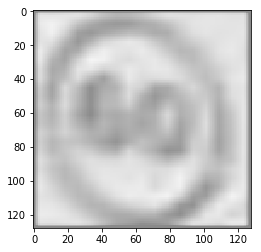

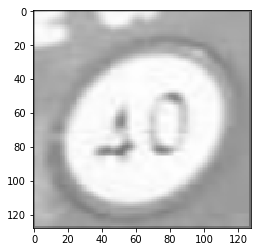

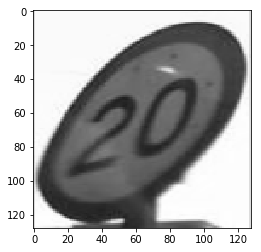

In [35]:
from PIL import Image

for image in images250[:3]:
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    plt.figure()
    plt.imshow(im)
    plt.show()



In [202]:
#Load Labels 
data = pd.read_csv("../data/train.csv")
data = data.sort_values("Img_Name").reset_index(drop=True)
labels = data["Label"]

labels.head()

0    Speed Limit 60
1    Speed Limit 40
2    Speed Limit 20
3    Speed Limit 40
4    Speed Limit 50
Name: Label, dtype: object

In [37]:
#categorize labels..

import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# y_train_labels = np.array(labels)
# X_train_data = np.array(images250)
y = np.array(labels)
X = np.array(images250)
X = X[:, :, :, np.newaxis] # (250,250) --> (467,250,250,1)

num_categories = 6

#encode labels
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y)
y_labels_categorized = to_categorical(y_labels_encoded, num_categories)

print('len(X)', len(X))
print('len(y)', len(y))
print('len(y_labels_categorized)', len(y_labels_categorized))

len(X) 467
len(y) 467
len(y_labels_categorized) 467


In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels_categorized, test_size=0.2, random_state=42)

In [10]:
# OLD MODEL

# input_shape = (250, 250, 1)

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last'))
# # model.add(Conv2D(32, (3, 3), activation='relu'))
# # model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))

# # model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(MaxPool2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))
# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_categories, activation='softmax'))

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# model.summary()

In [193]:
# MODEL #1 -- Basic Non-convolutional

model = Sequential()
model.add(Flatten(input_shape=(128,128,1)))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=6,activation="softmax"))
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [194]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
373/373 [==============================] - 2s 6ms/step - loss: 3.3883 - acc: 0.2252
Epoch 2/5
373/373 [==============================] - 1s 2ms/step - loss: 2.1282 - acc: 0.2574
Epoch 3/5
373/373 [==============================] - 1s 2ms/step - loss: 1.7971 - acc: 0.2654
Epoch 4/5
373/373 [==============================] - 1s 2ms/step - loss: 1.7748 - acc: 0.3083
Epoch 5/5
373/373 [==============================] - 1s 2ms/step - loss: 1.8926 - acc: 0.3137


In [41]:
accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32)
accuracy

94/94 [==============================] - 0s 1ms/step


[2.213308445950772, 0.1808510647809252]

In [223]:
# MODEL #2 -- Convolutional test 

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(128,128,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# from keras.optimizers import SGD
# opt = SGD(lr=0.05)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', #opt
              metrics=['accuracy']) 

# NOTE: If loss=categorical_crossentropy, 
# then 'accuracy' metrics == categorical_accruacy

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_142 (Dropout)        (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 28, 28, 64)        18496     
__________

In [220]:
# data_gen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=False,
#     fill_mode="nearest",
#     channel_shift_range=0.2,
# )


# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# data_gen.fit(X_train)

# # fits the model on batches with real-time data augmentation:
# # model.fit_generator(train_gen.flow(X_train, y_train, batch_size=32),
# #                     steps_per_epoch=len(X_train) / 32, epochs=20)

# import os
# os.makedirs('../data/image_data_gen')

# i = 0
# for X_batch, y_batch in data_gen.flow(X_train, y_train, batch_size=5, save_to_dir='../data/image_data_gen', save_prefix='aug', save_format='jpg'):
#     i += 1
#     if i == 500:
#         break

# print("done.")

In [224]:
train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    channel_shift_range=0.2,
)

validation_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_gen.fit(X_train)
validation_gen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(train_gen.flow(X_train, y_train, batch_size=32),
                    validation_data=validation_gen.flow(X_test, y_test, batch_size=32),
                    validation_steps=800 // 32,
                    steps_per_epoch=len(X_train) / 32, epochs=60)



Epoch 1/60
12/11 [==============================] - 15s 1s/step - loss: 1.8134 - acc: 0.1734 - val_loss: 1.7849 - val_acc: 0.1926
Epoch 2/60
12/11 [==============================] - 13s 1s/step - loss: 1.7307 - acc: 0.2751 - val_loss: 1.7783 - val_acc: 0.1798
Epoch 3/60
12/11 [==============================] - 13s 1s/step - loss: 1.7437 - acc: 0.2738 - val_loss: 1.7746 - val_acc: 0.1905
Epoch 4/60
12/11 [==============================] - 15s 1s/step - loss: 1.7537 - acc: 0.2620 - val_loss: 1.7780 - val_acc: 0.1811
Epoch 5/60
12/11 [==============================] - 14s 1s/step - loss: 1.7369 - acc: 0.2958 - val_loss: 1.7713 - val_acc: 0.2028
Epoch 6/60
12/11 [==============================] - 13s 1s/step - loss: 1.7266 - acc: 0.2906 - val_loss: 1.7749 - val_acc: 0.1880
Epoch 7/60
12/11 [==============================] - 13s 1s/step - loss: 1.7213 - acc: 0.2894 - val_loss: 1.7697 - val_acc: 0.1926
Epoch 8/60
12/11 [==============================] - 14s 1s/step - loss: 1.7368 - acc: 0.28

In [47]:
# model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
373/373 [==============================] - 9s 23ms/step - loss: 0.5692 - acc: 0.7712
Epoch 2/10
373/373 [==============================] - 7s 19ms/step - loss: 0.4951 - acc: 0.8110
Epoch 3/10
373/373 [==============================] - 8s 22ms/step - loss: 0.4817 - acc: 0.8155
Epoch 4/10
373/373 [==============================] - 7s 20ms/step - loss: 0.4728 - acc: 0.8248
Epoch 5/10
373/373 [==============================] - 7s 20ms/step - loss: 0.4710 - acc: 0.8172
Epoch 6/10
373/373 [==============================] - 7s 20ms/step - loss: 0.4730 - acc: 0.8222
Epoch 7/10
373/373 [==============================] - 8s 20ms/step - loss: 0.4724 - acc: 0.8195
Epoch 8/10
373/373 [==============================] - 8s 22ms/step - loss: 0.4547 - acc: 0.8284
Epoch 9/10
373/373 [==============================] - 8s 21ms/step - loss: 0.4625 - acc: 0.8253
Epoch 10/10
373/373 [==============================] - 8s 20ms/step - loss: 0.4505 - acc: 0.8257


In [227]:
accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32)
accuracy

94/94 [==============================] - 1s 15ms/step


[1.3147414212531232, 0.5212765944764969]

In [228]:
predictions = model.predict(X_test)
print('First prediction:', predictions[0])

predict_max = [max(class_probs) for class_probs in predictions]
print('Average predicted class probability:', np.mean(predict_max))

correct = [1 if np.argmax(predictions[i])==np.argmax(y_test[i]) else 0 for i in range(len(y_test))]
print("%-correct: ", np.mean(correct))

predictions[0:5]


First prediction: [0.17887121 0.16367513 0.28095844 0.12713197 0.08883171 0.16053157]
Average predicted class probability: 0.35321146
%-correct:  0.5212765957446809


array([[0.17887121, 0.16367513, 0.28095844, 0.12713197, 0.08883171,
        0.16053157],
       [0.1908056 , 0.20678797, 0.2535918 , 0.12905635, 0.07991914,
        0.13983916],
       [0.21336073, 0.19090083, 0.21886715, 0.12031703, 0.10131042,
        0.15524384],
       [0.1367436 , 0.18153988, 0.5262999 , 0.03528975, 0.0307708 ,
        0.08935603],
       [0.22041169, 0.2002247 , 0.17836325, 0.13393682, 0.11472762,
        0.15233585]], dtype=float32)